### 获取特征矩阵

In [1]:
import scipy

def get_feature_dict(filename):
    """将ninapro_feature的MAT文件加载为字典

    Args:
        path: mat文件路径
        filename: mat文件名

    Returns:
        数据集字典
        [feat_set, featStim, featRep]
    """
    # 读取MAT文件
    print('load file: ' + filename + '...', end= '', flush=True)
    dict_feature=scipy.io.loadmat(filename)
    if (dict_feature != ()):
        #print(ninapro_data.keys())
        print('[ok]:%d'%(len(dict_feature['featStim'])), flush=True)
    # 返回字典
    return dict_feature



In [ ]:
import numpy as np

feature_dict = get_feature_dict("../feature/feature_S1s20.mat")
index = []
for i in range(len(feature_dict['featStim'])):
    if feature_dict['featStim'][i]!=0:
        index.append(i)
emg_feature = feature_dict['feat_set'][index,:,:]
labels = feature_dict['featStim'][index,:]
print(emg_feature.shape)

In [4]:

import numpy as np
# 多人合并训练
def merge_multisubject(b,e):
    emg_feature = None
    labels = None
    for i in range(b,e+1):
        print("loading file:","../feature/feature_S{0}.mat".format(i),end='',flush=True)
        feature_dict = get_feature_dict("../feature/feature_S{0}.mat".format(i))
        print('[ok]',len(feature_dict['featStim']),flush=True)
        index = []
        for i in range(len(feature_dict['featStim'])):
            if feature_dict['featStim'][i]!=0:
                index.append(i)
        if(emg_feature is None):
            emg_feature = feature_dict['feat_set'][index,:,:]
            labels = feature_dict['featStim'][index,:]
        else:
            emg_feature = np.vstack((emg_feature,feature_dict['feat_set'][index,:,:])) 
            labels = np.vstack((labels,feature_dict['featStim'][index,:]))
    return emg_feature,labels
emg_feature,labels = merge_multisubject(1,4)
print(emg_feature.shape)

loading file: ../feature/feature_S1.matload file: ../feature/feature_S1.mat...[ok]:206751
[ok] 206751
loading file: ../feature/feature_S2.matload file: ../feature/feature_S2.mat...[ok]:206659
[ok] 206659
loading file: ../feature/feature_S3.matload file: ../feature/feature_S3.mat...[ok]:207104
[ok] 207104
loading file: ../feature/feature_S4.matload file: ../feature/feature_S4.mat...[ok]:206841
[ok] 206841
(403854, 12, 10)


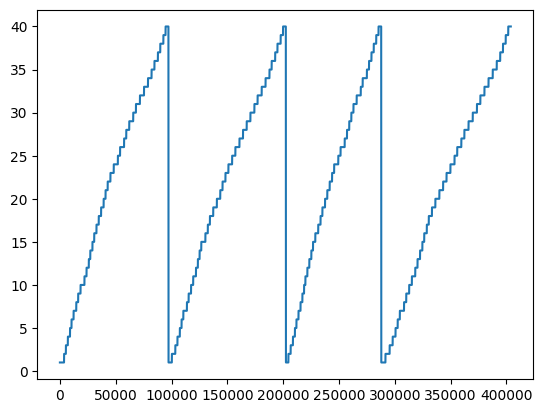

In [5]:
import matplotlib.pyplot as plt
plt.plot(labels)

### 模型结构

In [ ]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from torchsummary import summary
import torch.nn.functional as F


class GengNet(nn.Module):
    def __init__(self, class_num=None, base_features=64, window_length=256, input_channels=6):
        super(GengNet, self).__init__()
        self.class_num = class_num
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1,  # for EMG images, the channels is 1. not the signal channels: input_channels
                      out_channels=base_features,
                      kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(base_features),
            nn.ReLU(),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=base_features,
                      out_channels=base_features,
                      kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(base_features),
            nn.ReLU(),
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=base_features,
                      out_channels=base_features,
                      kernel_size=1, stride=1),
            nn.BatchNorm2d(base_features),
            nn.ReLU(),
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=base_features,
                      out_channels=base_features,
                      kernel_size=1, stride=1),
            nn.BatchNorm2d(base_features),
            nn.ReLU(),
            nn.Dropout(p=0.5),
        )

        self.fcn1 = nn.Sequential(
            nn.Linear(base_features * window_length * input_channels, 512),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Dropout(p=0.5)
        )
        self.fcn2 = nn.Linear(128, self.class_num)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)

        x = self.fcn1(x.view(x.size(0), -1))
        x = self.fcn2(x)
        x = F.softmax(x, dim=1)
        return x
        
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("The model will be running on", device, "device")
model_test = GengNet(class_num=40,base_features=16,window_length=10,input_channels=12).to(device)
summary(model_test,(1,12,10))

In [ ]:
import time
def testAccuracy(device, model, test_loader):
    
    model.eval()
    accuracy = 0.0
    total = 0.0
    
    with torch.no_grad():
        for data in test_loader:
            emg_data, labels = data
            emg_data = Variable(emg_data.to(device))    # torch.Size([64, 1, 200, 12])
            labels = Variable(labels.to(device))        # torch.Size([64])
            # run the model on the test set to predict labels
            outputs = model(emg_data)
            # the label with the highest energy will be our prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            accuracy += (predicted == labels).sum().item()
    
    # compute the accuracy over all test images
    accuracy = (100 * accuracy / total)
    return(accuracy)

def train(device, num_epochs, train_loader, test_loader):
    best_accuracy = 0
    model = models.resnet18(num_classes=40)
    model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
    model = model.to(device)
    loss_func = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    
    train_accs = []
    train_loss = []
    test_accs = []

    for epoch in range(num_epochs):
        running_loss = 0.0
        for i,(inputs, labels) in enumerate(train_loader,0):#0是下标起始位置默认为0
            # data 的格式[[inputs, labels]]       
    #         inputs,labels = data
            inputs = Variable(inputs.to(device))    # torch.Size([64, 1, 200, 12])
            labels = Variable(labels.to(device))        # torch.Size([64]) 
            #初始为0，清除上个batch的梯度信息
            optimizer.zero_grad()         

            #前向+后向+优化     
            outputs = model(inputs)
            loss = loss_func(outputs,labels.long())
            loss.backward()
            optimizer.step()

            # loss 的输出，每个一百个batch输出，平均的loss
            running_loss += loss.item()
            if i%100 == 99:
                print('[%d,%5d] loss :%.3f' %
                    (epoch+1,i+1,running_loss/100),end='',flush=True)
                running_loss = 0.0
            train_loss.append(loss.item())

            # 训练曲线的绘制 一个batch中的准确率
            correct = 0
            total = 0
            _, predicted = torch.max(outputs.data, 1)
            total = labels.size(0)# labels 的长度
            correct = (predicted == labels).sum().item() # 预测正确的数目
            train_accs.append(100*correct/total)
            if i%100 == 99:
                print(' acc=%d'%(100*correct/total))
            
        accuracy = testAccuracy(device, model, test_loader)
        print('For epoch', epoch+1,'the test accuracy over the whole test set is %d %%' % (accuracy))
        # we want to save the model if the accuracy is the best
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            torch.save(model.state_dict(), "../model/best_epoch{1}_{0}.pth".format(epoch, (int(time.time())%1000000)))


In [6]:
import torchvision.transforms as tt
# 矩阵数据预处理
emg_feature = np.expand_dims(emg_feature,axis=1)*1e3
emg_feature = emg_feature.astype(np.float32)
labels = labels.flatten() - 1

print('reshaped data:',emg_feature.shape)

print('get dataloader...', end='',flush=True)
emg_feature_t = torch.tensor(emg_feature)
labels_t = torch.tensor(labels)
torch_dataset = torch.utils.data.TensorDataset(emg_feature_t, labels_t)

# 划分数据集与训练集
test_size = int(len(labels)*0.2)
train_dataset,test_dataset = torch.utils.data.random_split(dataset=torch_dataset,lengths = [len(labels)-test_size,test_size])
train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset,      # torch TensorDataset format
    batch_size=32,      # mini batch size
    shuffle=True,               # 要不要打乱数据 (打乱比较好)
    num_workers=2,              # 多线程来读数据
    drop_last = True,
   
)
test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset,      # torch TensorDataset format
    batch_size=64,      # mini batch size
    shuffle=False,               # 要不要打乱数据 (打乱比较好)
    num_workers=2,              # 多线程来读数据
    drop_last = True,
)
print('[ok]')
print('begin to train.....')
# 模型训练
train(device, 50, train_loader, test_loader)

For epoch 3 the test accuracy over the whole test set is 34 %
[4,  100] loss :3.394 acc=34
[4,  200] loss :3.383 acc=50
[4,  300] loss :3.314 acc=43
[4,  400] loss :3.379 acc=28
[4,  500] loss :3.362 acc=37
[4,  600] loss :3.336 acc=34
[4,  700] loss :3.366 acc=31
[4,  800] loss :3.345 acc=40
[4,  900] loss :3.334 acc=43
[4, 1000] loss :3.362 acc=21
